In [1]:
#%reload_ext autoreload

#%autoreload 2

#%matplotlib inline

from PIL import Image
from resmem import ResMem, transformer
model = ResMem(pretrained=True)

import logging
import sys
import os
import re
import math
import itertools
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


import statsmodels.api as sm
import statsmodels.tools as tools

import random
import glob
import seaborn as sns
from pathlib import Path
import datetime
import warnings

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

/Users/kaylaxu/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kaylaxu/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
ratings = pd.read_csv('attribute_means.csv')  # mean scores of 34 features 
ratings.head()


stimulus  trustworthy  attractive   dominant      smart        age  \
0         1    43.673077   46.552632  79.771429  55.405405  50.404255   
1         2    65.000000   59.750000  48.666667  57.891892  31.300000   
2         3    37.010526   36.000000  65.428571  65.057143  51.745098   
3         4    64.053191   65.500000  47.194444  54.700000  24.777778   
4         5    69.577320   50.702703  56.257143  61.527778  44.534884   

      gender     weight    typical      happy  ...   hispanic   islander  \
0  86.891892  38.119048  66.736842  18.970588  ...  18.828571  12.470588   
1  12.560976  48.275000  49.209302  75.771429  ...  70.325000  63.236842   
2  74.789474  44.790698  48.666667  23.135135  ...  44.375000  27.108108   
3   9.526316  32.375000  44.024390  59.526316  ...  61.666667  60.352941   
4  14.650000  40.250000  70.184211  82.600000  ...  14.162162  15.121212   

      native      black      white  looks-like-you        gay  electable  \
0  13.925926   5.105263  92.970588       31.428571  20.523810  61.486486   
1  54.564516  72.735294   4.880952       13.465116  31.414634  66.184211   
2  33.898305   3.972222  68.787879       18.363636  46.024390  70.804878   
3  49.824561  72.552632   3.315789       10.500000  20.365854  57.179487   
4  10.910714   3.702703  88.842105       19.000000  21.783784  70.888889   

       godly   outdoors  
0  53.439024  83.925000  
1  62.809524  57.513514  
2  55.921053  11.292683  
3  62.051282  16.560976  
4  71.833333  20.777778  

[5 rows x 35 columns]

In [ ]:
for file in glob.glob('/Users/kaylaxu/Desktop/ResMem_model/omi-main/images/*.jpg')[:30]:
    jpgName = file.split("/")[-1]
    print(jpgName.split(".")[0])

In [23]:
#get target values
allScores = np.zeros(len(ratings))

for file in glob.glob('/Users/kaylaxu/Desktop/ResMem_model/omi-main/images/*.jpg'):
    img = Image.open(file) # This loads your image into memory
    img = img.convert('RGB') 
    # This will convert your image into RGB, for instance if it's a PNG (RGBA) or if it's black and white.
    jpgName = file.split("/")[-1]
    index = jpgName.split(".")[0]
    
    model.eval()
    # Set the model to inference mode.

    image_x = transformer(img)
    # Run the preprocessing function

    prediction = model(image_x.view(-1, 3, 227, 227))
    # For a single image, the image must be reshaped into a batch
    # with size 1.
    # Get your prediction!
    
    allScores[int(index)-1] = prediction


In [24]:
allScores

array([0.88542271, 0.9026264 , 0.9414826 , ..., 0.94194841, 0.85302466,
       0.8427797 ])

In [234]:
## input : a dataframe with features and targetCol

## filter out features with a correlation coefficient >0.9

## select a model to use: linearReg (linear) or xgboost (nonlinear, tree-based)

## return importances : features vs importances


def regression_model(df,target, modelname='linearReg', modelFeatures=None):
    if (modelFeatures != None):
        X = df[modelFeatures]
    else:
        X=df.drop(["stimulus"], axis =1)
    feature_cols = X.columns
    Y=target


    ##  ****step 1 **** correlation:

    plt.figure(figsize=(20,20))
    dataplot = sns.heatmap(df[feature_cols].corr(), cmap="coolwarm", annot=True, fmt='.2g')
    plt.show()

    corrMatrix=df[feature_cols].corr().abs()
    upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.90

    corrFutures = [column for column in upperMatrix.columns if any(upperMatrix[column] > 0.90)]
    print(corrFutures)

    ## drop those
    ## only used those
    

    features = [ x for x in feature_cols if x not in corrFutures]
    X=X[features]

    ### ****step 2 ****scale and split data *******
    ## scale X

    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X)
    X = pd.DataFrame(X_scale, columns = X.columns)

    # splits the training and test data set in 80% : 20%

    # assign random_state to any value.This ensures consistency.

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

    ##    **** step 3 ****** model ******

    if modelname=='linearReg':
        lin_model = LinearRegression()
        lin_model.fit(X_train, Y_train)
        #predict
        y_test_predict = lin_model.predict(X_test)
        #importances
        importances = pd.DataFrame({'feature': features, 'importance':lin_model.coef_}).sort_values('importance')
       

        ## check the importances
        modsm = sm.OLS(Y_train, sm.add_constant(X_train))
        res=modsm.fit()
        print(res.summary())

        # nonlinear regression
    elif modelname=='xgboost':

        # Fit xgboost
        model = xgb.XGBRegressor(tree_method='hist')
        model.fit(X_train, Y_train )
        y_test_predict = model.predict(X_test )

        # importances
        temp = sorted( dict(zip(model.get_booster().feature_names,model.feature_importances_)).items(), key=lambda item:item[1], reverse=True)
        sorted_features, sorted_mean_feat_importances = list(zip(*temp))
        importances = pd.DataFrame({'feature':sorted_features,'importance':sorted_mean_feat_importances})

    else:
        print("Error: no model is selected")
        return
    # ideally should have been a straight line
    # Visualize the regression results:
    
    print('residual', (sum((Y_test - y_test_predict)**2 )/len(Y_test ) )**0.5)

    plt.figure(figsize=(10,10))
    plt.scatter(Y_test, y_test_predict)
    plt.plot([0.5,1],[0.5,1],'r--',lw=3)
    plt.xlabel(' Target value',fontsize=20)
    plt.ylabel(' Predicted value', fontsize=20)
    plt.title("XGBoost: 31 Facial Attributes Against ResMem Memorability Score")
    plt.grid()
    plt.axis('equal')
    plt.xlim([0.7, 1])
    plt.ylim([0.7, 1])
    plt.show()
    

    return importances

In [124]:
topRegressors

['long-haired',
 'age',
 'liberal',
 'skin-color',
 'privileged',
 'trustworthy',
 'gay',
 'memorable',
 'hair-color',
 'black']

In [ ]:
# only for top 10 features
LR_importances = regression_model(ratings,allScores, modelname='linearReg', modelFeatures = topRegressors) 

print(LR_importances)

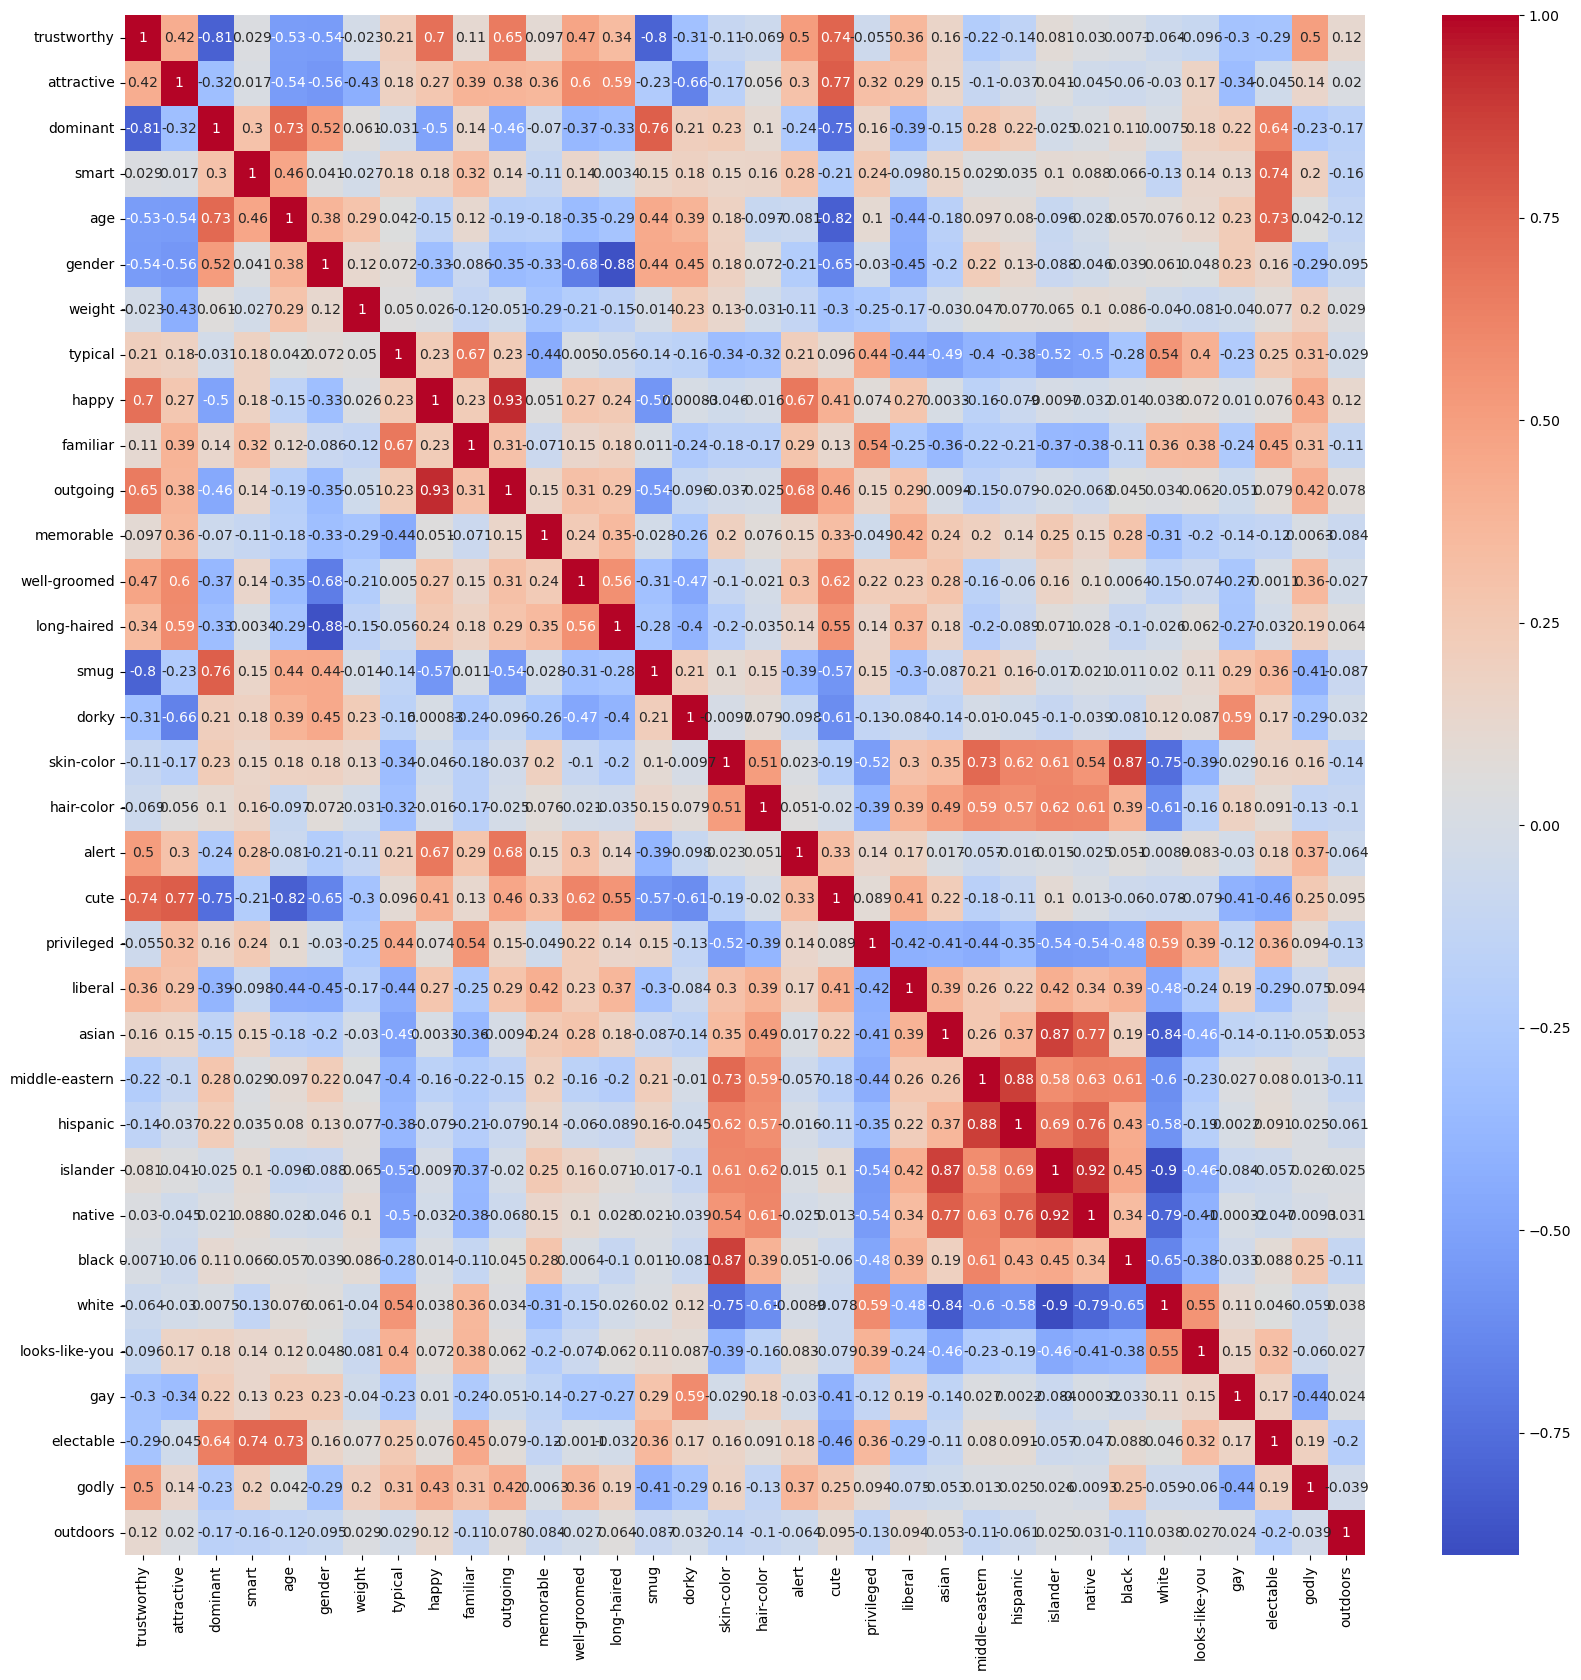

/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/149023371.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


['outgoing', 'native', 'white']
residual 0.04170239298707352


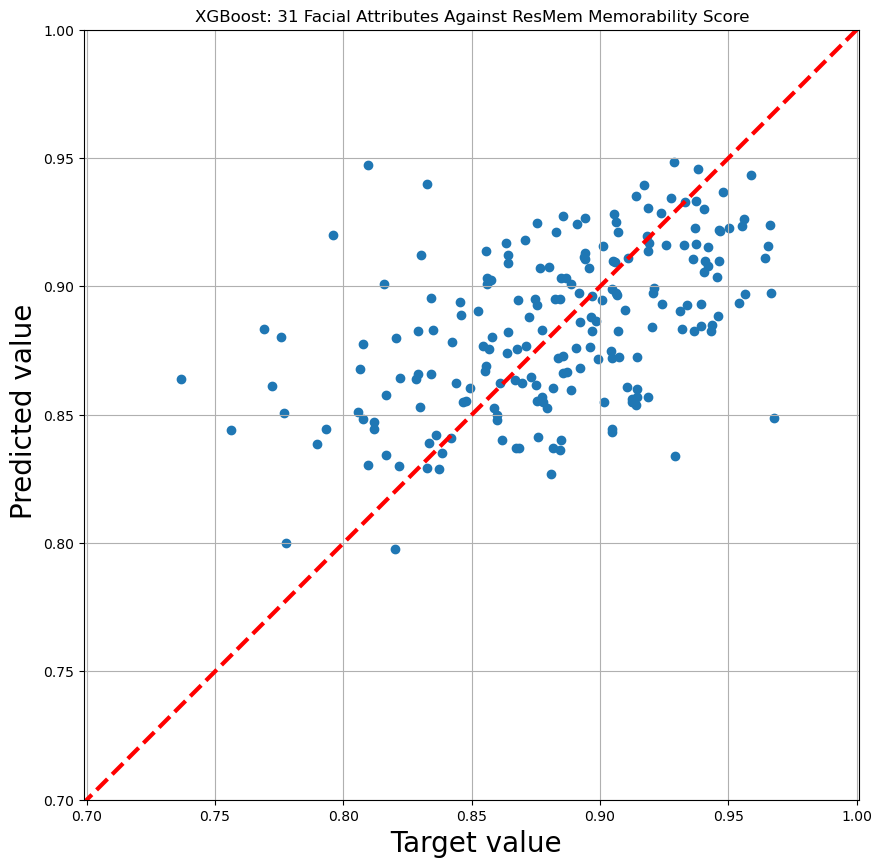

           feature  importance
0      long-haired    0.186567
1        electable    0.071398
2           gender    0.061763
3              gay    0.047673
4              age    0.038504
5   middle-eastern    0.037295
6            asian    0.036488
7         hispanic    0.034501
8            alert    0.033425
9            black    0.033089
10        outdoors    0.032695
11      privileged    0.031692
12        islander    0.026681
13      hair-color    0.025449
14            cute    0.025035
15         liberal    0.024437
16  looks-like-you    0.021895
17            smug    0.021589
18       memorable    0.020527
19           godly    0.019949
20        familiar    0.019609
21           dorky    0.019334
22      skin-color    0.019227
23    well-groomed    0.017852
24        dominant    0.017120
25         typical    0.016975
26           smart    0.016037
27          weight    0.012769
28           happy    0.012563
29      attractive    0.009290
30     trustworthy    0.008573


In [235]:
# for all features
XG_importances = regression_model(ratings,allScores, modelname='xgboost')
print(XG_importances)

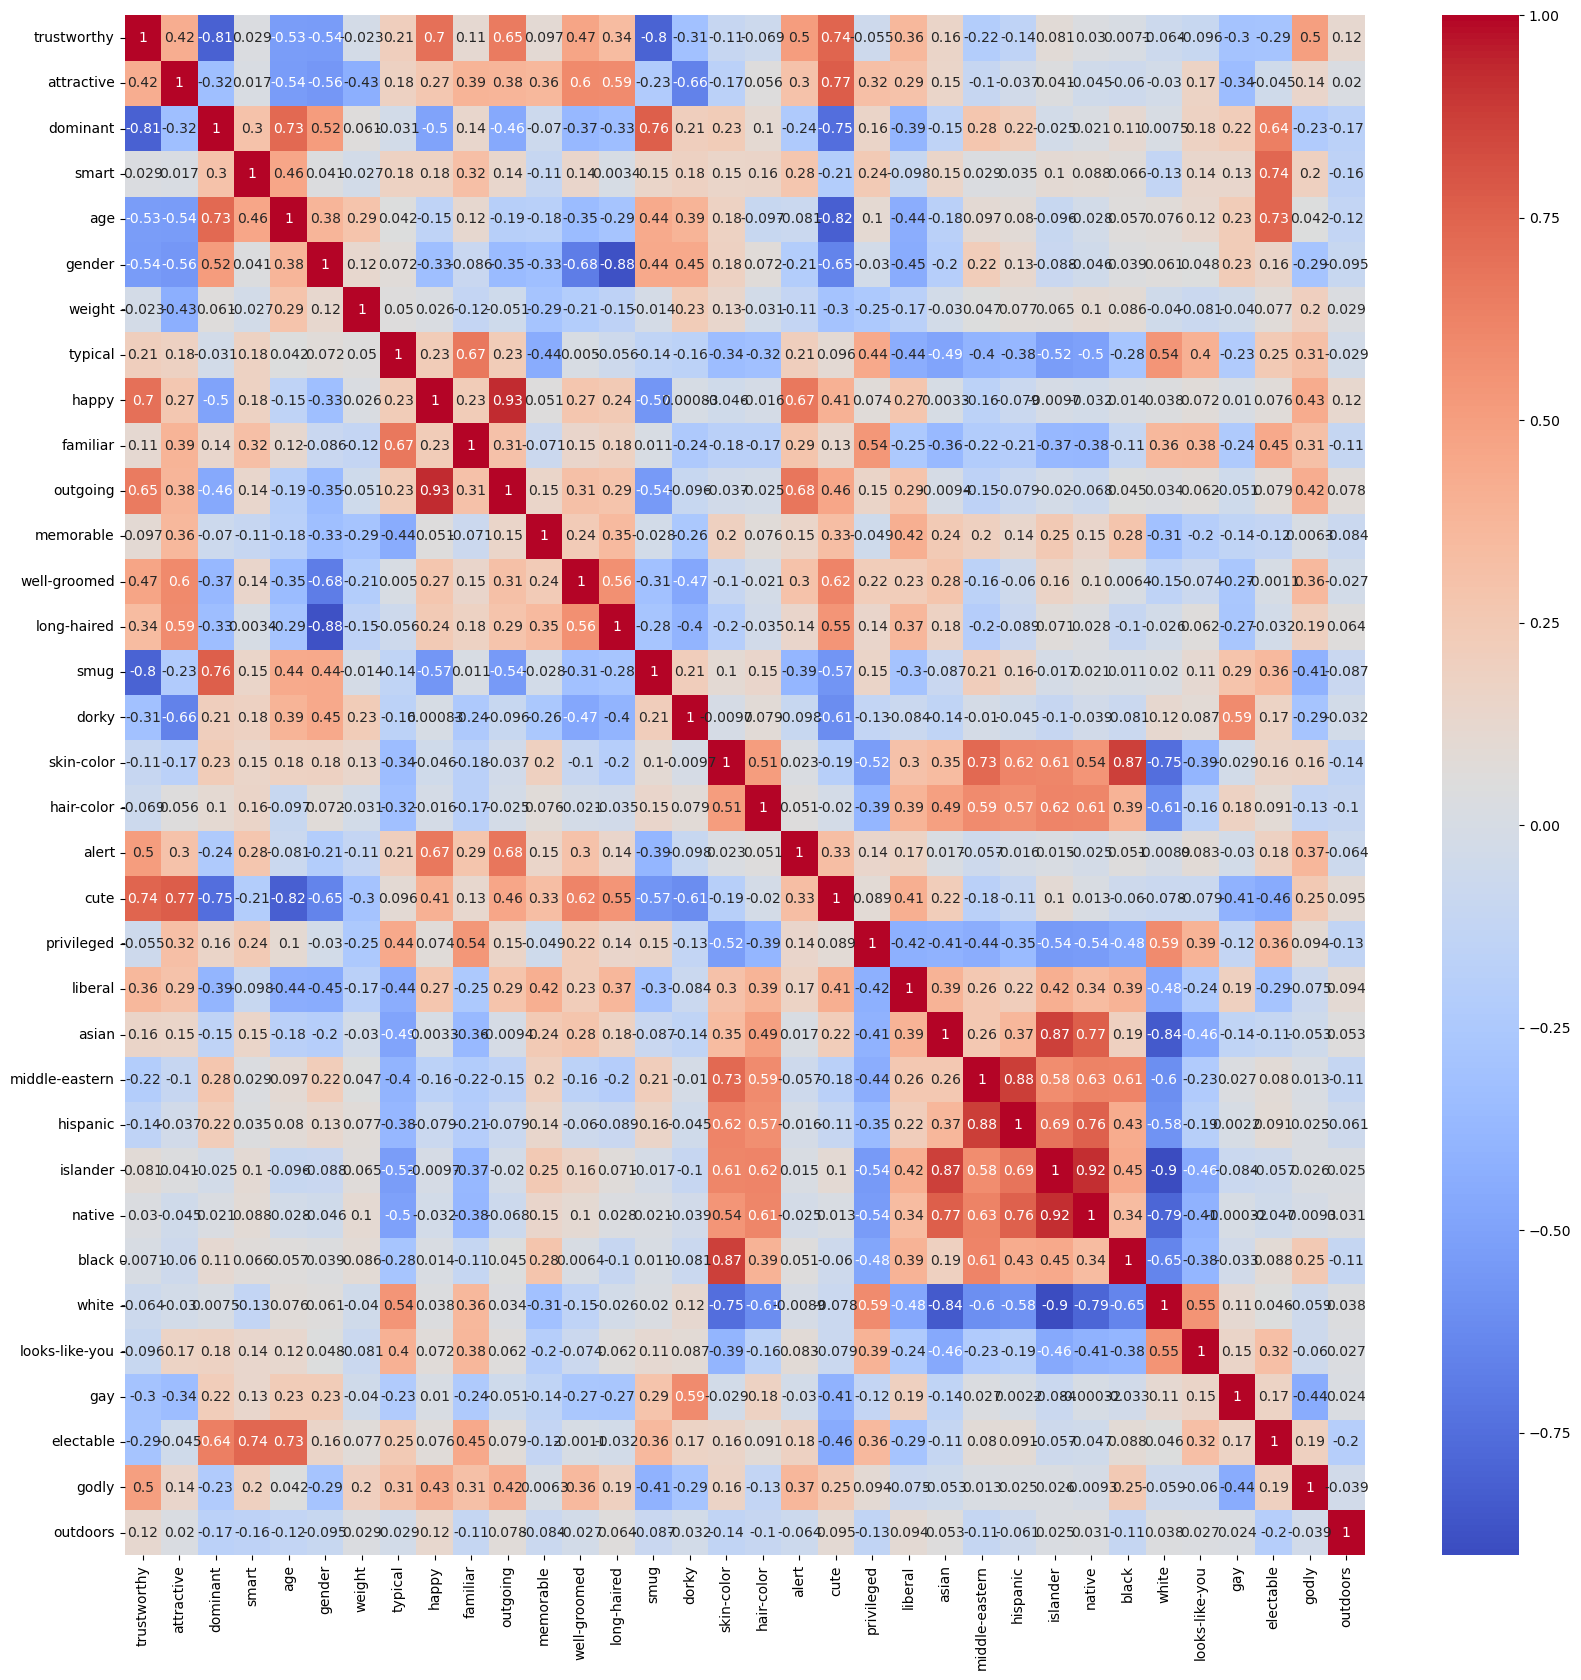

/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/149023371.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


['outgoing', 'native', 'white']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     14.51
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           7.85e-58
Time:                        17:26:34   Log-Likelihood:                 1536.9
No. Observations:                 803   AIC:                            -3010.
Df Residuals:                     771   BIC:                            -2860.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const       

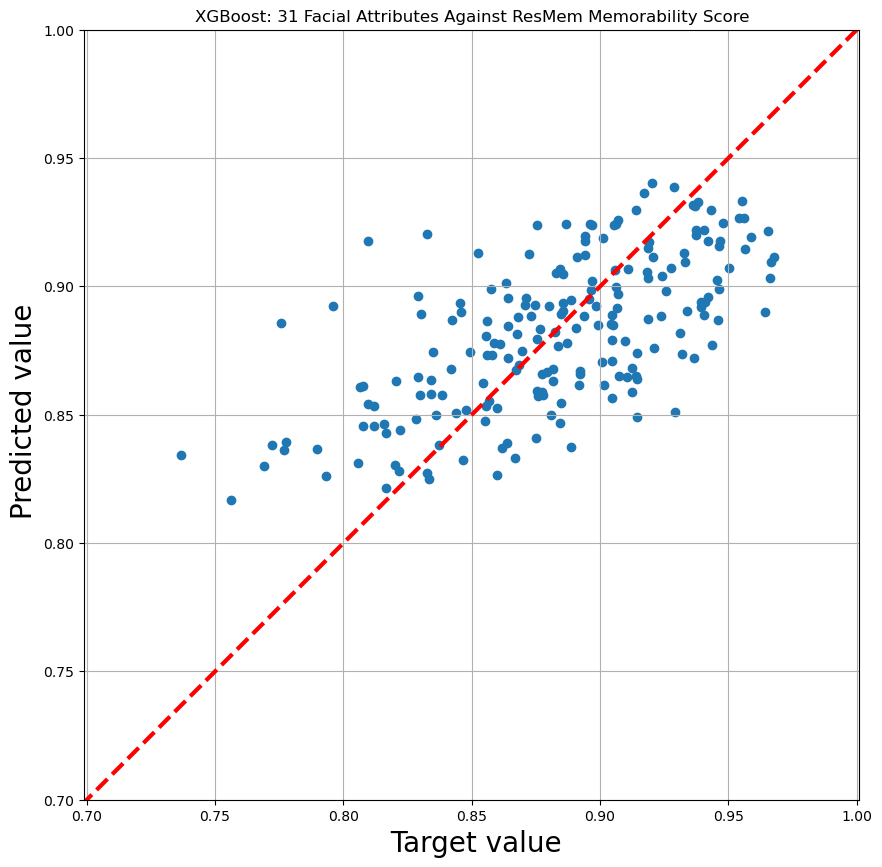

           feature  importance
12     long-haired   -0.054509
20         liberal   -0.042902
25           black   -0.024992
21           asian   -0.017604
8            happy   -0.014871
13            smug   -0.013221
30        outdoors   -0.011660
23        hispanic   -0.008254
11    well-groomed   -0.003471
7          typical   -0.003170
28       electable   -0.002034
2         dominant    0.000070
6           weight    0.002054
17           alert    0.003329
3            smart    0.004260
29           godly    0.006106
26  looks-like-you    0.008234
5           gender    0.008562
1       attractive    0.009500
9         familiar    0.010147
18            cute    0.012298
14           dorky    0.014913
22  middle-eastern    0.020476
24        islander    0.024427
16      hair-color    0.027151
10       memorable    0.027872
27             gay    0.028872
0      trustworthy    0.030273
19      privileged    0.031684
15      skin-color    0.042310
4              age    0.050406


In [236]:
LR_coeffs = regression_model(ratings,allScores, modelname='linearReg')
print(LR_coeffs)

In [220]:
sortedLR = LR_coeffs.sort_values(by='importance', key=pd.Series.abs, ascending=False)
sortedLR[:10]


feature  importance
12  long-haired   -0.054509
4           age    0.050406
20      liberal   -0.042902
15   skin-color    0.042310
19   privileged    0.031684
0   trustworthy    0.030273
27          gay    0.028872
10    memorable    0.027872
16   hair-color    0.027151
25        black   -0.024992

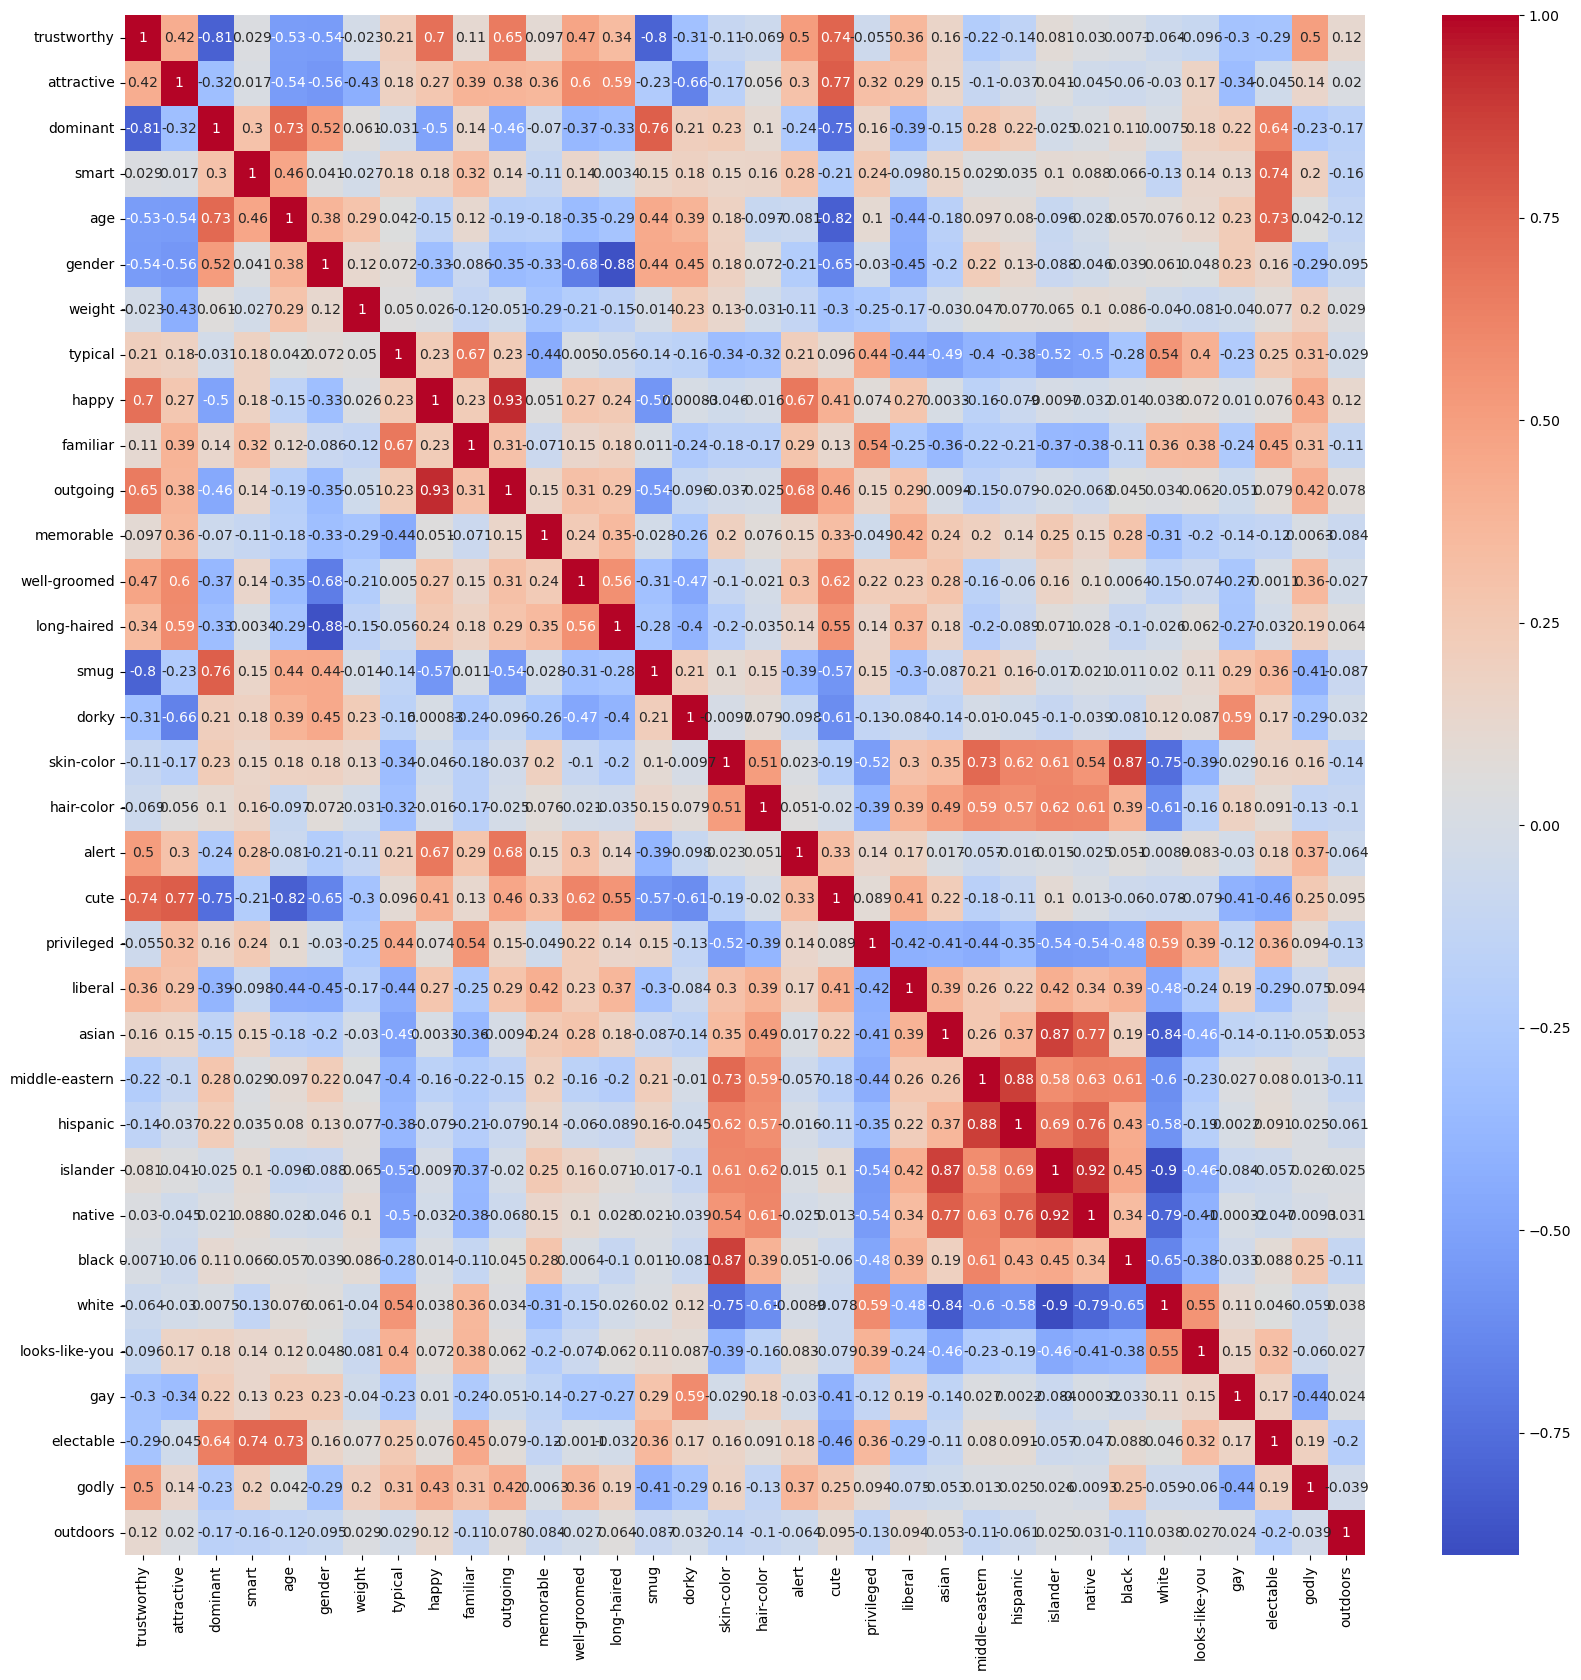

/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/2516225850.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


['outgoing', 'native', 'white']
here


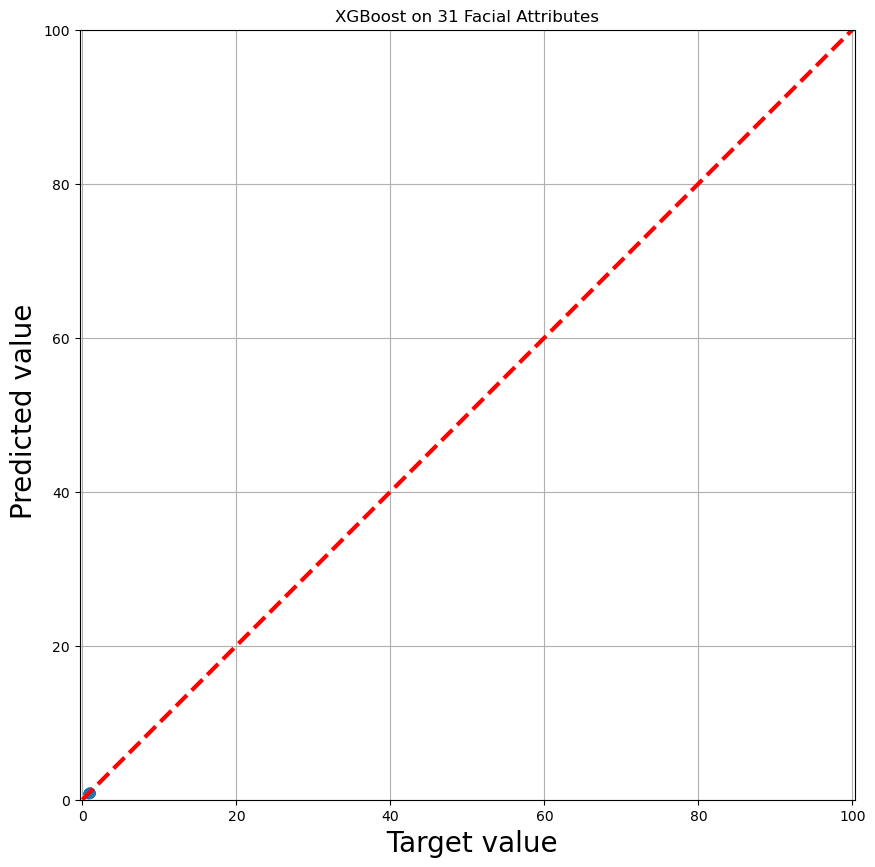

           feature  importance
0      long-haired    0.186567
1        electable    0.071398
2           gender    0.061763
3              gay    0.047673
4              age    0.038504
5   middle-eastern    0.037295
6            asian    0.036488
7         hispanic    0.034501
8            alert    0.033425
9            black    0.033089
10        outdoors    0.032695
11      privileged    0.031692
12        islander    0.026681
13      hair-color    0.025449
14            cute    0.025035
15         liberal    0.024437
16  looks-like-you    0.021895
17            smug    0.021589
18       memorable    0.020527
19           godly    0.019949
20        familiar    0.019609
21           dorky    0.019334
22      skin-color    0.019227
23    well-groomed    0.017852
24        dominant    0.017120
25         typical    0.016975
26           smart    0.016037
27          weight    0.012769
28           happy    0.012563
29      attractive    0.009290
30     trustworthy    0.008573


feature  importance
0     long-haired    0.186567
1       electable    0.071398
2          gender    0.061763
3             gay    0.047673
4             age    0.038504
5  middle-eastern    0.037295
6           asian    0.036488
7        hispanic    0.034501
8           alert    0.033425
9           black    0.033089

In [149]:
XG_importances = regression_model(ratings,allScores, modelname='xgboost')
print(XG_importances)
XG_importances[:10]


In [185]:
XG_importances.feature[:10].tolist()

['long-haired',
 'electable',
 'gender',
 'gay',
 'age',
 'middle-eastern',
 'asian',
 'hispanic',
 'alert',
 'black']

'\nfeature = \'attractive\'\nplt.figure()\nplt.plot(ratings[feature], allScores, \'.\')\nplt.xlabel(f\'{feature} rating\')\nplt.ylabel("Memorability Score as Predicted by ResMem")\nplt.grid()\n'

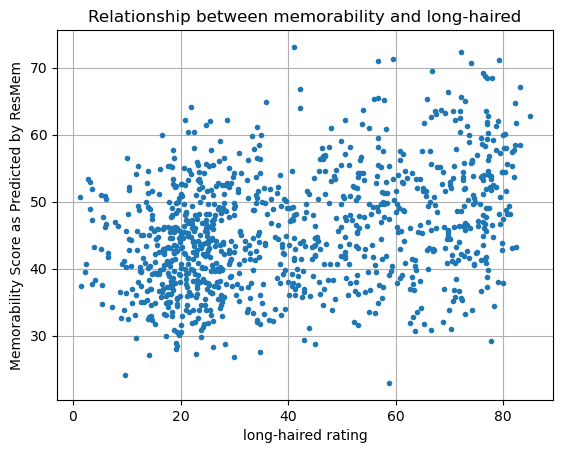

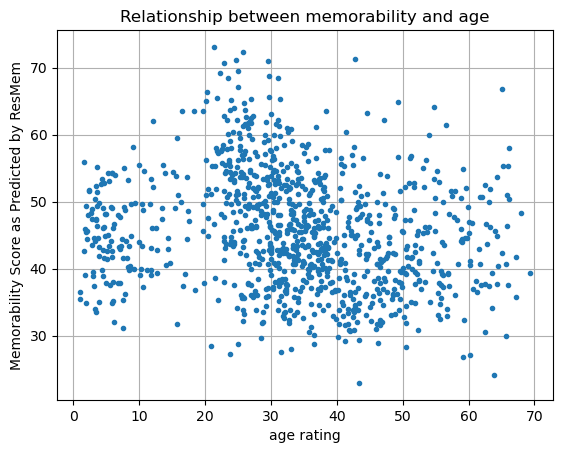

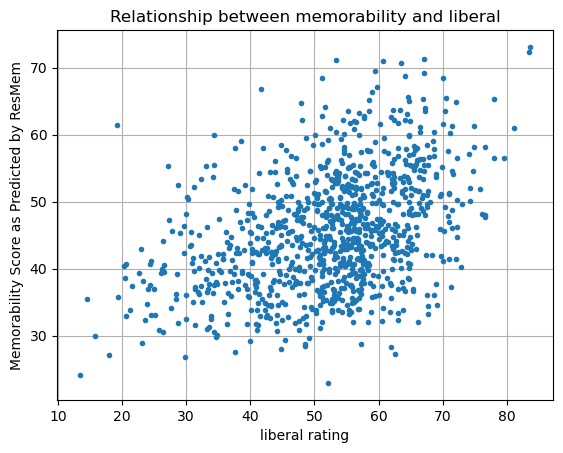

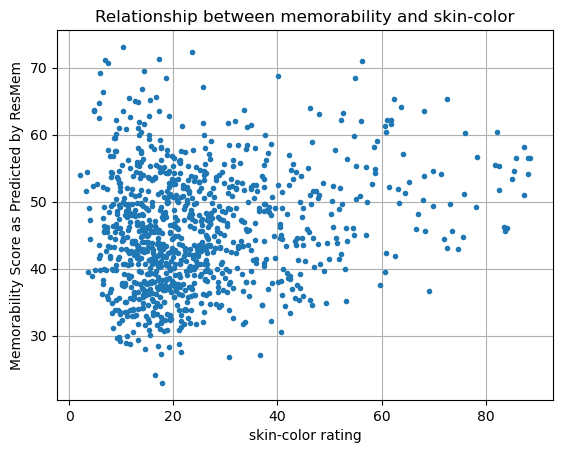

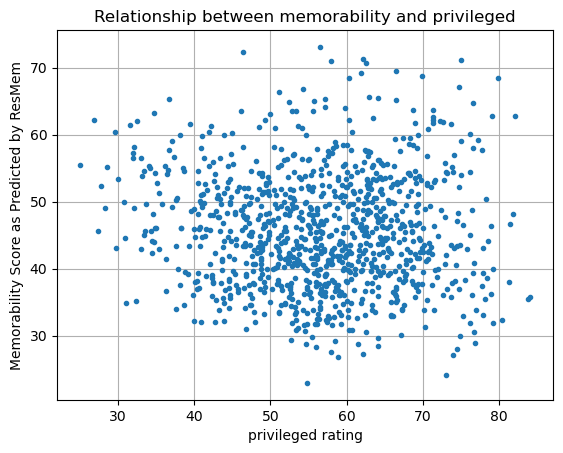

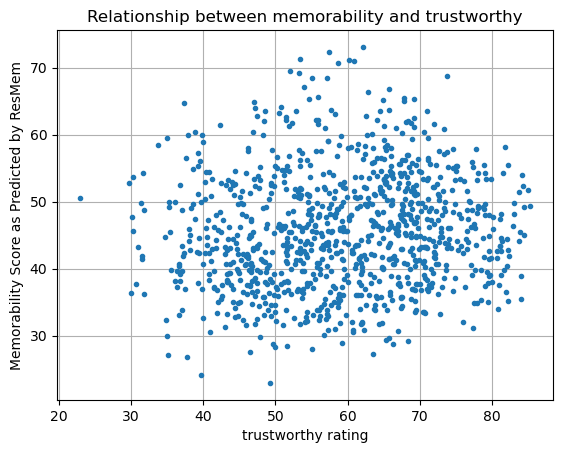

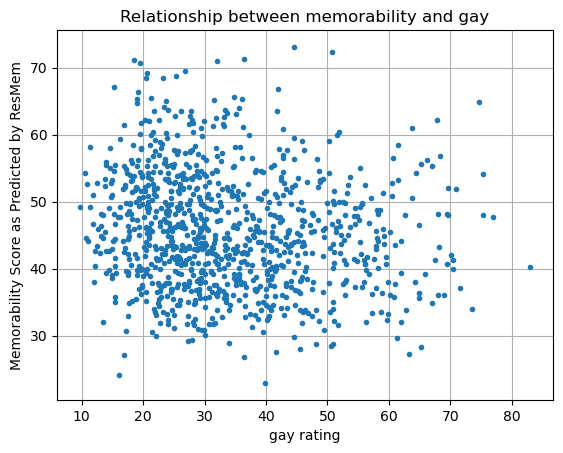

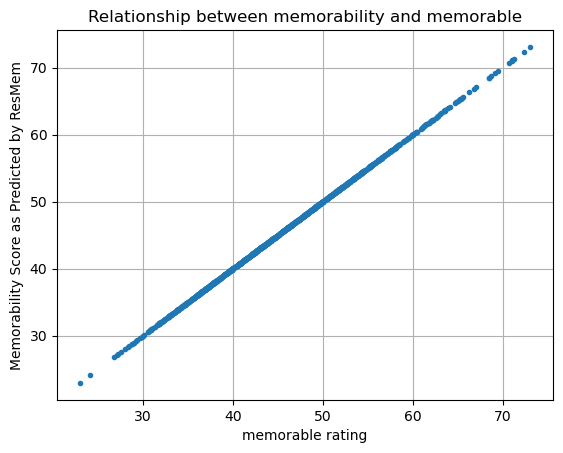

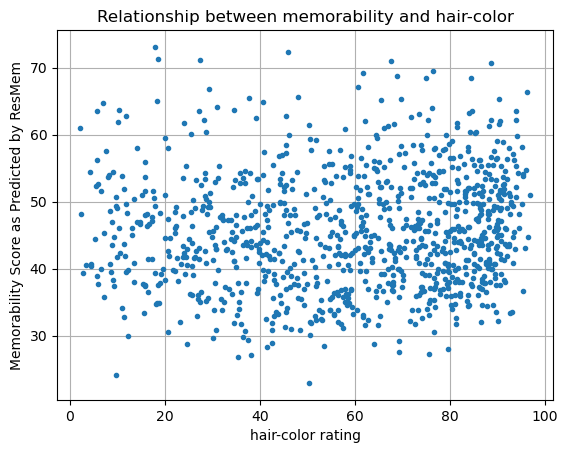

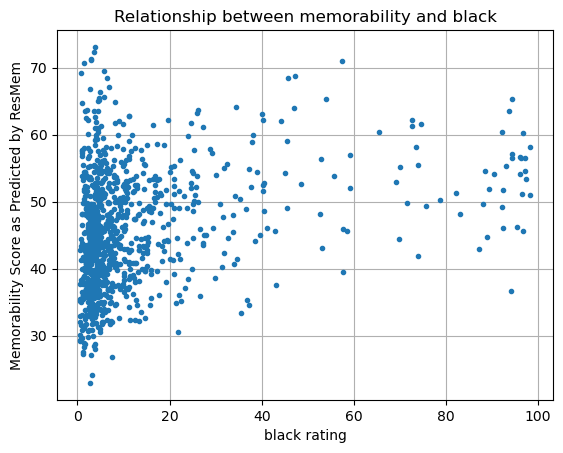

In [202]:
# long haired rating is negatively correlated


for feature in topRegressors:
    plt.figure()
    plt.plot(ratings[feature], ratings['memorable'], '.')
    plt.xlabel(f'{feature} rating')
    plt.ylabel("Memorability Score as Predicted by ResMem")
    plt.grid()
    plt.title(f'Relationship between memorability and {feature}')
    
'''
feature = 'attractive'
plt.figure()
plt.plot(ratings[feature], allScores, '.')
plt.xlabel(f'{feature} rating')
plt.ylabel("Memorability Score as Predicted by ResMem")
plt.grid()
'''


# positive 

In [108]:
ratings['memorable'].max()

73.09090909

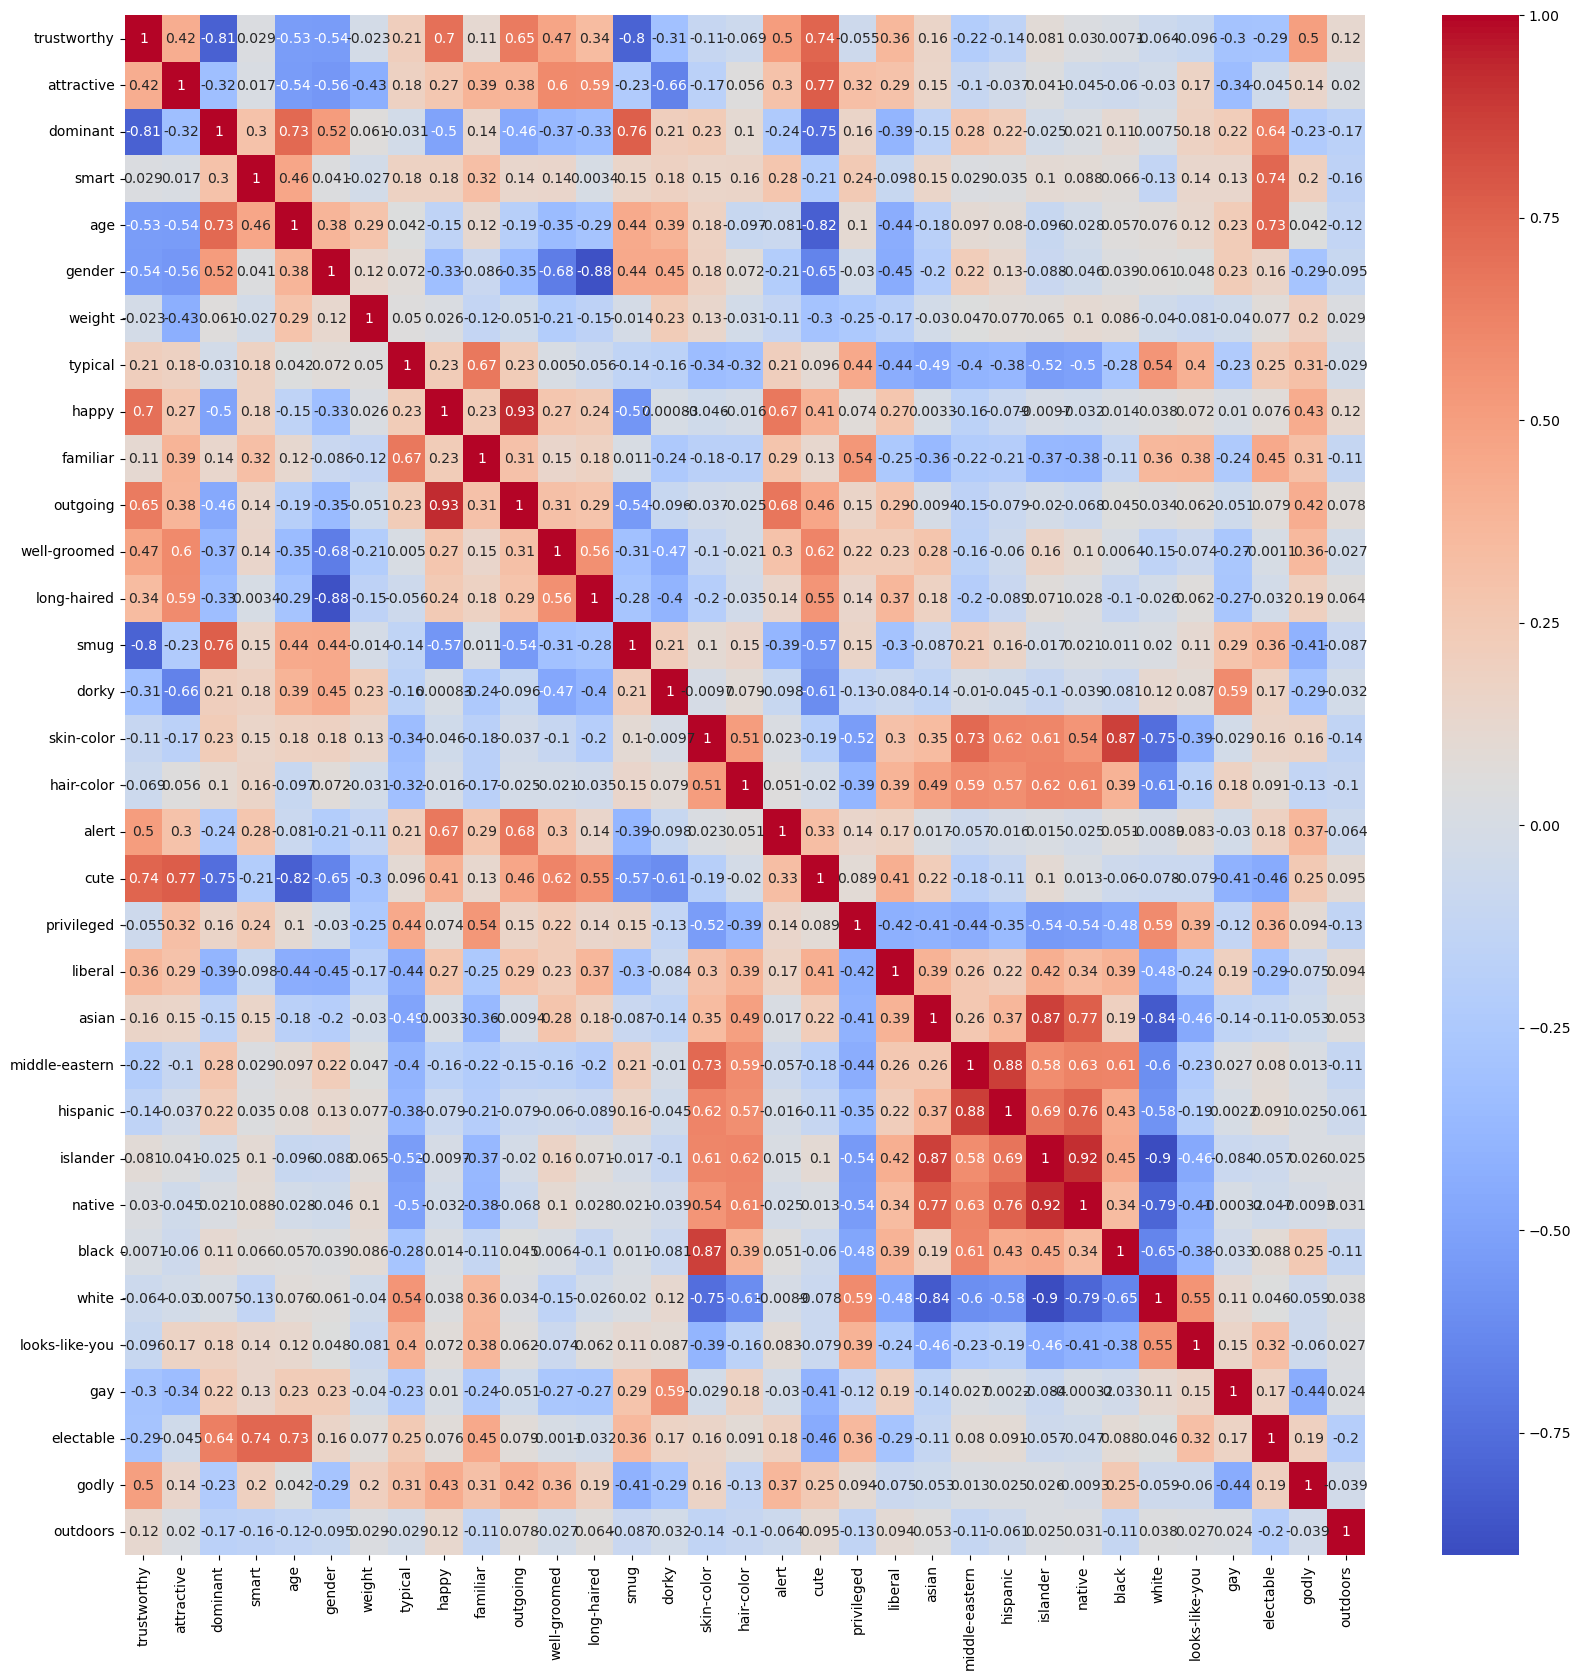

['outgoing', 'native', 'white']
                            OLS Regression Results                            
Dep. Variable:              memorable   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     39.26
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.07e-133
Time:                        19:14:09   Log-Likelihood:                -2491.6
No. Observations:                 803   AIC:                             5045.
Df Residuals:                     772   BIC:                             5191.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const       

/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/3810579329.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


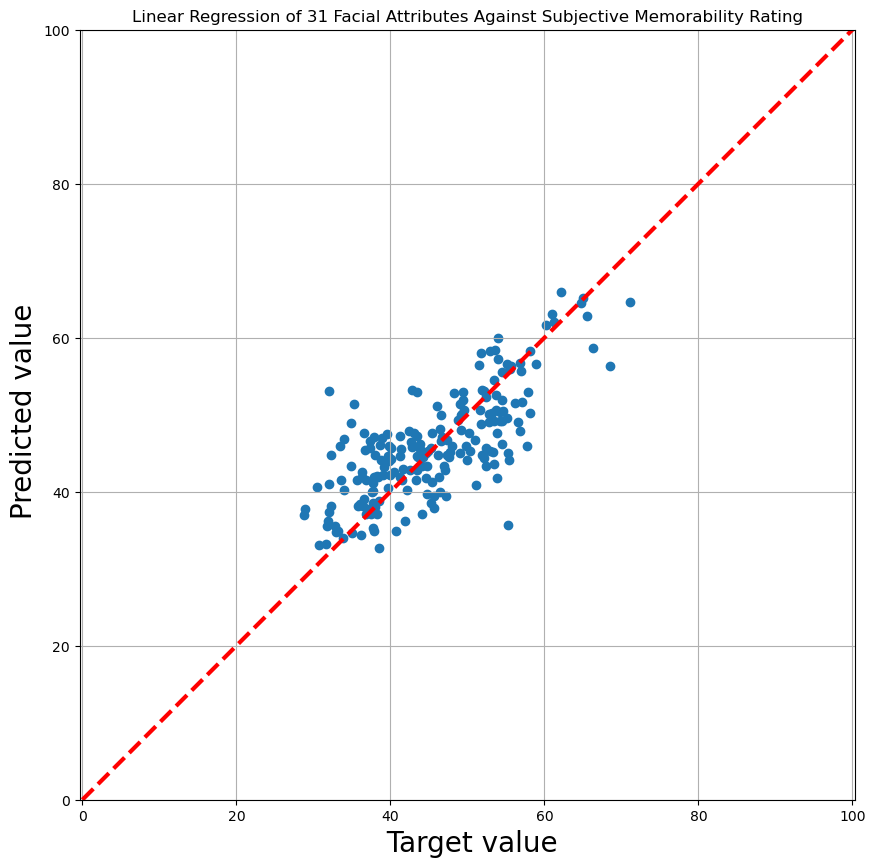

           feature  importance
7          typical  -25.543126
22        hispanic  -10.742997
3            smart   -7.367074
26             gay   -6.722348
6           weight   -6.623968
10    well-groomed   -6.319365
27       electable   -5.518924
15      hair-color   -4.429536
20           asian   -4.112491
14      skin-color   -3.194450
28           godly   -2.763652
29        outdoors   -2.508477
25  looks-like-you   -1.118654
8            happy   -0.901260
5           gender    0.267676
11     long-haired    2.480820
9         familiar    3.543041
18      privileged    3.697699
12            smug    3.727330
19         liberal    5.642898
0      trustworthy    6.383115
16           alert    7.581209
23        islander    7.767267
21  middle-eastern    7.841619
13           dorky    8.683786
24           black    8.702132
2         dominant   12.095524
1       attractive   12.908551
4              age   18.854141
17            cute   21.791626


In [157]:
LR_memorable = regression_model(ratings.drop(['memorable'], axis = 1),ratings['memorable'], modelname='linearReg') 
print(LR_memorable)

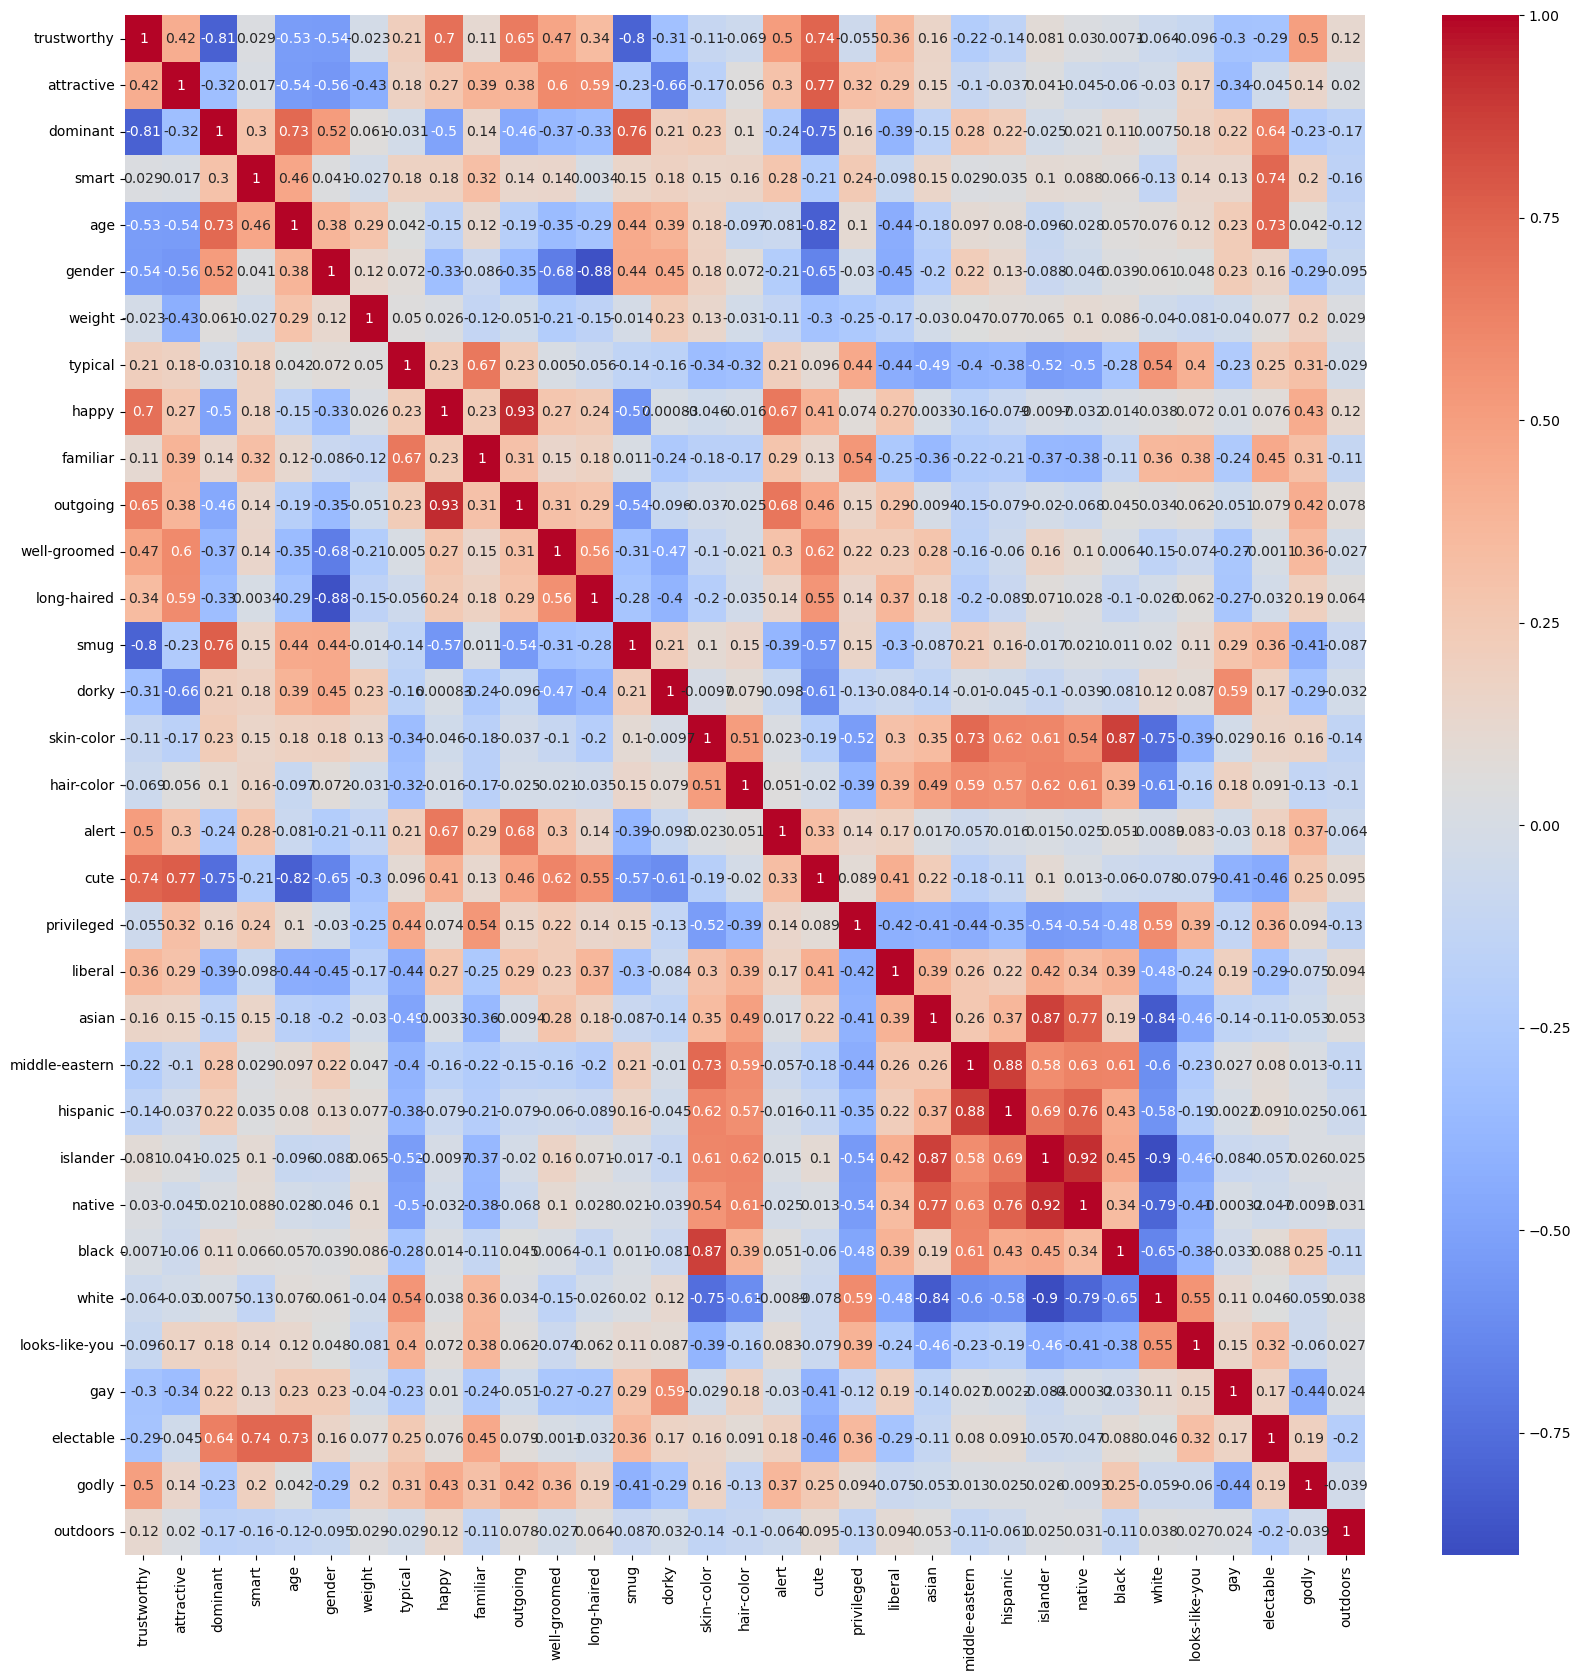

/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/3123107720.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


['outgoing', 'native', 'white']
                            OLS Regression Results                            
Dep. Variable:              memorable   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     39.26
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.07e-133
Time:                        21:22:26   Log-Likelihood:                -2491.6
No. Observations:                 803   AIC:                             5045.
Df Residuals:                     772   BIC:                             5191.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const       

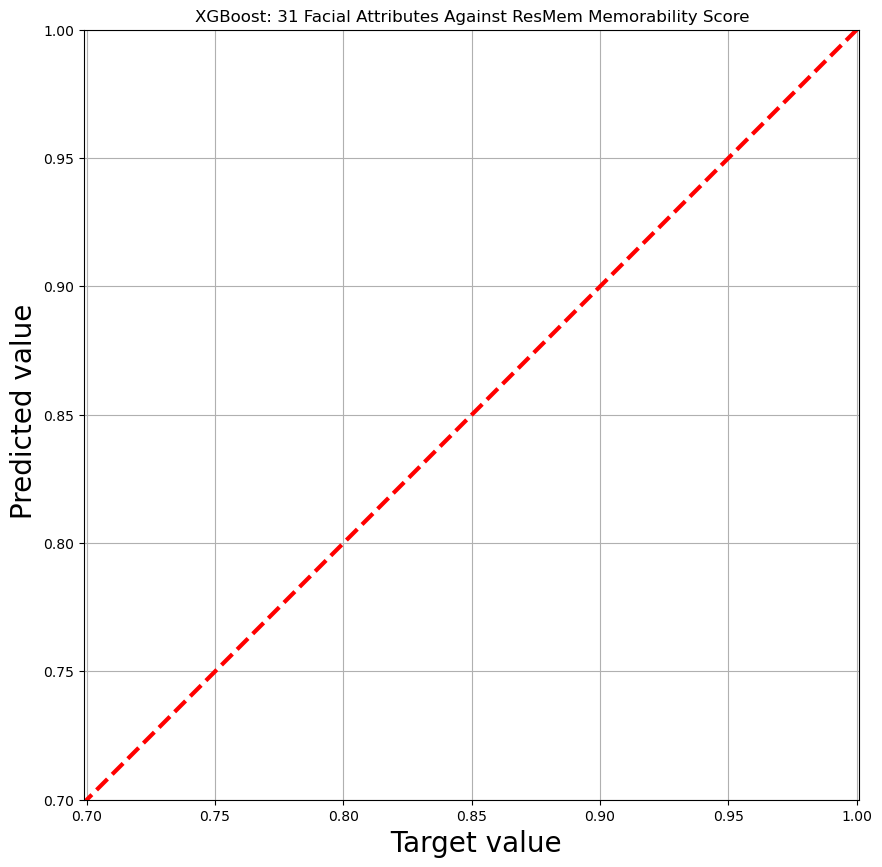

           feature  importance
7          typical  -25.543126
22        hispanic  -10.742997
3            smart   -7.367074
26             gay   -6.722348
6           weight   -6.623968
10    well-groomed   -6.319365
27       electable   -5.518924
15      hair-color   -4.429536
20           asian   -4.112491
14      skin-color   -3.194450
28           godly   -2.763652
29        outdoors   -2.508477
25  looks-like-you   -1.118654
8            happy   -0.901260
5           gender    0.267676
11     long-haired    2.480820
9         familiar    3.543041
18      privileged    3.697699
12            smug    3.727330
19         liberal    5.642898
0      trustworthy    6.383115
16           alert    7.581209
23        islander    7.767267
21  middle-eastern    7.841619
13           dorky    8.683786
24           black    8.702132
2         dominant   12.095524
1       attractive   12.908551
4              age   18.854141
17            cute   21.791626


['typical',
 'cute',
 'age',
 'attractive',
 'dominant',
 'hispanic',
 'black',
 'dorky',
 'middle-eastern',
 'islander']

In [201]:
LR_memorable = regression_model(ratings.drop(['memorable'], axis = 1),ratings['memorable'], modelname='linearReg') 
print(LR_memorable)
sortedLR = LR_memorable.sort_values(by='importance', key=pd.Series.abs, ascending=False)
topFeatures = sortedLR.feature[:10].tolist()
topFeatures

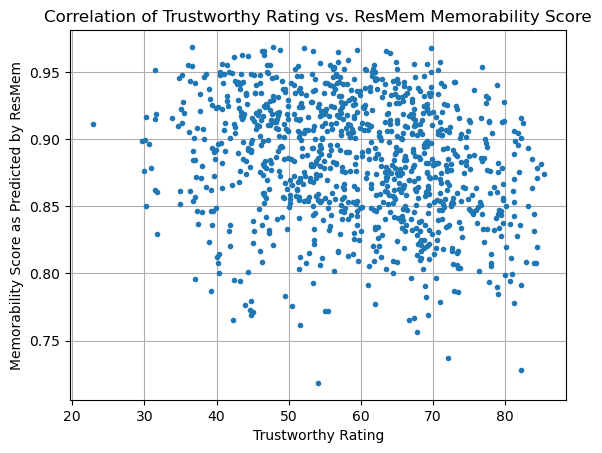

In [182]:
feature = 'trustworthy'
featureName = 'Trustworthy'
plt.figure()
plt.plot(ratings[feature], allScores, '.')
plt.xlabel(f'{featureName} Rating')
plt.ylabel("Memorability Score as Predicted by ResMem")
plt.title(f"Correlation of {featureName} Rating vs. ResMem Memorability Score")
plt.grid()

In [125]:
topRegressors

['long-haired',
 'age',
 'liberal',
 'skin-color',
 'privileged',
 'trustworthy',
 'gay',
 'memorable',
 'hair-color',
 'black']

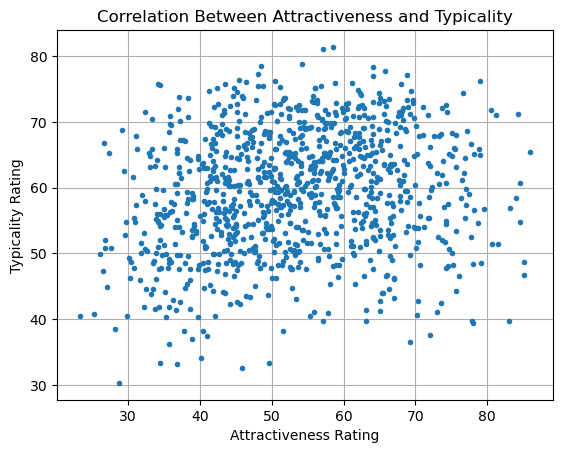

In [129]:
feature = 'attractive'
feature2 = 'typical'
plt.figure()
plt.plot(ratings[feature], ratings[feature2], '.')
plt.xlabel(f'Attractiveness Rating')
plt.ylabel("Typicality Rating")
plt.title("Correlation Between Attractiveness and Typicality")
plt.grid()

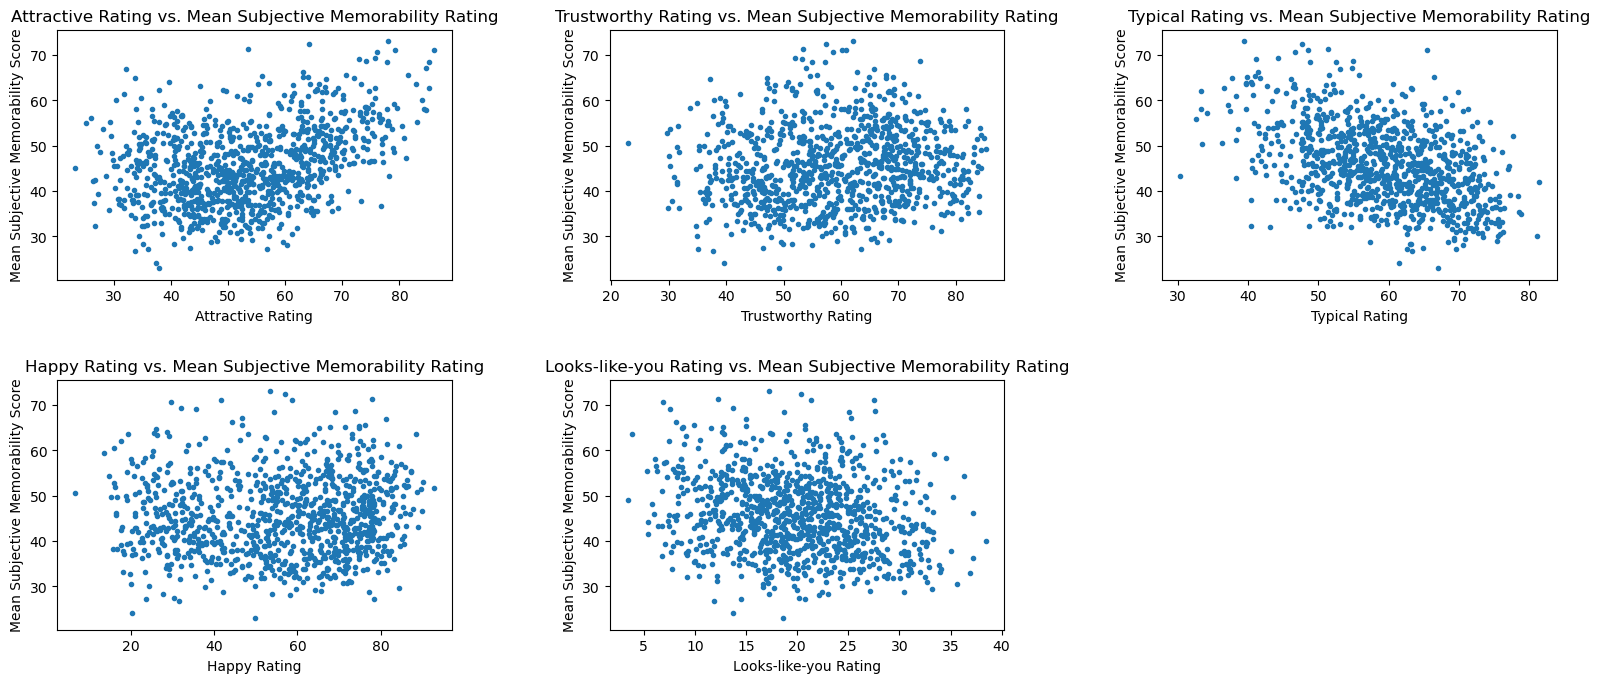

In [225]:
fig = plt.figure(figsize=(10, 5))
features = ['attractive', 'trustworthy', 'typical', 'happy', 'looks-like-you']



# iterate over the function list and add a subplot for each function
for idx, feature in enumerate(features, start=1):  
    ax = fig.add_subplot(2, 3, idx) # plot with 2 rows and 3 columns
    ax.plot(ratings[feature], ratings['memorable'], '.')
    cap = feature[0].upper()
    ax.set_title(f"{cap}{feature[1:]} Rating vs. Mean Subjective Memorability Rating")
    ax.set_xlabel(f"{cap}{feature[1:]} Rating")
    ax.set_ylabel(f"Mean Subjective Memorability Score")

# add spacing between subplots
plt.subplots_adjust(left=0.1,
                    right=1.6,
                    top = 1.7,
                    bottom = 0.5,
                    wspace=0.4, 
                    hspace=0.4)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, idx)
regression_model(ratings.drop(['memorable'], axis = 1),ratings['memorable'], modelname='linearReg') 

In [189]:
def regression_plot(df,target, modelname='linearReg', modelFeatures=None):
    if (modelFeatures != None):
        X = df[modelFeatures]
    else:
        X=df.drop(["stimulus"], axis =1)
    feature_cols = X.columns
    Y=target


    ##  ****step 1 **** correlation:

    corrMatrix=df[feature_cols].corr().abs()
    upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.90

    corrFutures = [column for column in upperMatrix.columns if any(upperMatrix[column] > 0.90)]
    print(corrFutures)

    ## drop those
    ## only used those
    

    features = [ x for x in feature_cols if x not in corrFutures]
    X=X[features]

    ### ****step 2 ****scale and split data *******
    ## scale X

    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X)
    X = pd.DataFrame(X_scale, columns = X.columns)

    # splits the training and test data set in 80% : 20%

    # assign random_state to any value.This ensures consistency.

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

    ##    **** step 3 ****** model ******

    if modelname=='linearReg':
        lin_model = LinearRegression()
        lin_model.fit(X_train, Y_train)
        #predict
        y_test_predict = lin_model.predict(X_test)
        #importances
        importances = pd.DataFrame({'feature': features, 'importance':lin_model.coef_}).sort_values('importance')
       

        ## check the importances
        modsm = sm.OLS(Y_train, sm.add_constant(X_train))
        res=modsm.fit()
        #print(res.summary())

        # nonlinear regression
    elif modelname=='xgboost':

        # Fit xgboost
        model = xgb.XGBRegressor(tree_method='hist')
        model.fit(X_train, Y_train )
        y_test_predict = model.predict(X_test )

        # importances 
        temp = sorted( dict(zip(model.get_booster().feature_names,model.feature_importances_)).items(), key=lambda item:item[1], reverse=True)
        sorted_features, sorted_mean_feat_importances = list(zip(*temp))
        importances = pd.DataFrame({'feature':sorted_features,'importance':sorted_mean_feat_importances})

    else:
        print("Error: no model is selected")
        return
    # ideally should have been a straight line
    # Visualize the regression results:
    

    return Y_test, y_test_predict

/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/2092125505.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
/var/folders/gr/91dbslhx1ps9sbgz3cgtkcqh0000gn/T/ipykernel_76332/2092125505.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uppe

['outgoing', 'native', 'white']
                            OLS Regression Results                            
Dep. Variable:              memorable   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     39.26
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.07e-133
Time:                        21:17:11   Log-Likelihood:                -2491.6
No. Observations:                 803   AIC:                             5045.
Df Residuals:                     772   BIC:                             5191.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const       

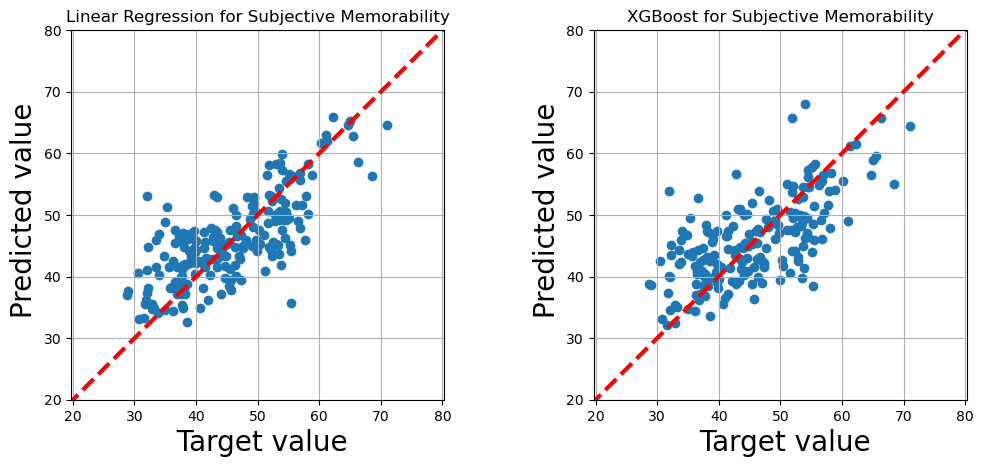

In [200]:
Y_test, y_test_predict = regression_plot(ratings.drop(['memorable'], axis = 1),ratings['memorable'], modelname='linearReg')
#fig = plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.scatter(Y_test, y_test_predict)
plt.plot([0,100],[0, 100],'r--',lw=3)
plt.xlabel(' Target value',fontsize=20)
plt.ylabel(' Predicted value', fontsize=20)
plt.title("Linear Regression for Subjective Memorability")
plt.grid()
plt.axis('equal')
plt.xlim([20, 80])
plt.ylim([20, 80])

Y_test, y_test_predict = regression_plot(ratings.drop(['memorable'], axis = 1),ratings['memorable'], modelname='xgboost')

plt.subplot(1, 2, 2)
plt.scatter(Y_test, y_test_predict)
plt.plot([0,100],[0, 100],'r--',lw=3)
plt.xlabel(' Target value',fontsize=20)
plt.ylabel(' Predicted value', fontsize=20)
plt.title("XGBoost for Subjective Memorability")
plt.grid()
plt.axis('equal')
plt.xlim([20, 80])
plt.ylim([20, 80])
plt.subplots_adjust(left=0.1,
                    right=1.5, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

